### gdna informations https://ftp.ncbi.nlm.nih.gov/genomes/GENOME_REPORTS/eukaryotes.txt

### mtdna informations https://www.ncbi.nlm.nih.gov/genome/browse#!/organelles/organelles.csv

### taxonomy descriptions https://ftp.ncbi.nih.gov/pub/taxonomy/new_taxdump/taxdump_readme.txt
### taxonomy informations https://ftp.ncbi.nih.gov/pub/taxonomy/new_taxdump/new_taxdump.zip és ebből a nodes.dmp
### taxonomy ranks Taxallnomy: an extension of NCBI Taxonomy that produces a hierarchically complete taxonomic tree (Table 1.) https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04304-3

In [1]:
#import dependencies
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
#get nuclear genome informations
gdnas=pd.read_csv('../data/eukaryotes.txt',sep='\t',index_col=0)
gdnas.head(n=2)

,TaxID,BioProject Accession,BioProject ID,Group,SubGroup,Size (Mb),GC%,Assembly Accession,Replicons,WGS,Scaffolds,Genes,Proteins,Release Date,Modify Date,Status,Center,BioSample Accession
#Organism/Name,,,,,,,,,,,,,,,,,,
Neopyropia yezoensis,2788,PRJNA589917,589917,Other,Other,107.591,64.8454,GCA_009829735.1,chromosome 1:CM020618.1; chromosome 2:CM020619...,WMLA01,28,-,-,2020/01/03,2020/01/06,Chromosome,Ocean University,SAMN13316713
Emiliania huxleyi CCMP1516,280463,PRJNA77753,77753,Protists,Other Protists,167.676,64.5,GCA_000372725.1,-,AHAL01,7795,38549,38554,2013/04/19,2014/08/01,Scaffold,JGI,SAMN02744062


In [3]:
#get mitochondrial genome informations
mtdnas=pd.read_csv('../data/organelles.csv',index_col=0)
mtdnas.head(n=2)

,Organism Groups,Strain,BioSample,BioProject,Size(Mb),GC%,Type,Replicons,CDS,Release Date
#Organism Name,,,,,,,,,,
(Cyprinus carpio 'mirror' x Cyprinus carpio 'singuonensis') x Carassius auratus red var.,Eukaryota;Animals;Fishes,NaN,NaN,PRJNA353408,0.016581,43.3207,mitochondrion,NC_031807.1/KU146531.1,13,2016-11-14T00:00:00Z
Aacanthocnema dobsoni,Eukaryota;Animals;Insects,NaN,NaN,PRJNA483618,0.015179,21.9382,mitochondrion,NC_038132.1/MG989216.1,13,2018-07-31T00:00:00Z


In [4]:
#get phylogenetic informations about nodes
nodes=pd.read_csv('../data/nodes.dmp',sep='\t',header=None)

#delete non informative columns
fil=nodes.apply(lambda column:len(column.unique())!=1,axis=0)
nodes=nodes[fil.index[fil]]

#rename existing columns
nodes.rename(columns={
    0:'tax_id',
    2:'parent_tax_id',
    4:'rank'
},inplace=True)
nodes.head(n=3)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tax_id,parent_tax_id,rank,6,8,10,12,14,16,18,20,24
0,1,1,no rank,NaN,8,0,1,0,0,0,0,NaN
1,2,131567,superkingdom,NaN,0,0,11,0,0,0,0,NaN
2,6,335928,genus,NaN,0,1,11,1,0,1,0,NaN


In [5]:
#taxonomy ranks input
taxonomy_ranks=[
        'superkingdom','kingdom','subkingdom','superphylum',
        'phylum','subphylum','infraphylum','superclass',
        'class','subclass','infraclass','cohort','subcohort',
        'superorder','order','suborder','infraorder','parvorder',
        'superfamily','family','subfamily','tribe','subtribe',
        'genus','subgenus','section','subsection','series',
        'subseries','species group','species subgroup',
        'species','forma specialis','subspecies',
        'varietas','subvariety','forma',
        'serogroup','serotype','strain','isolate'
    ]

In [6]:
#sort taxonomy ranks https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04304-3/tables/1
taxonomy_ranks=pd.Series(
    data=np.arange(0,len(taxonomy_ranks)),
    index=taxonomy_ranks
)

In [7]:
#get phylogenetic informations about nodes
rankedlineage=pd.read_csv('../data/rankedlineage.dmp',sep='\t',header=None)
rankedlineage=rankedlineage.rename(columns={
    0:'tax_id',
    2:'tax_name',
    4:'species',
    6:'genus',
    8:'family',
    10:'order',
    12:'order',
    14:'class',
    16:'phylum',
    18:'kingdom',
    20:'superkingdom'
                          })
#delete non informative columns
fil=rankedlineage.apply(lambda column:len(column.unique())!=1,axis=0)
rankedlineage=rankedlineage[fil.index[fil]]
rankedlineage=rankedlineage.dropna()
rankedlineage.head(n=2)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,8,10,12,14,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tax_id,tax_name,species,genus,family,order,order,order,order,class,phylum,kingdom
556755,2678697,[Arthonia] cinnabarina f. cuspidans,Coniocarpon cinnabarinum,Coniocarpon,Arthoniaceae,Arthoniales,Arthoniomycetes,Arthoniales,Arthoniomycetes,Ascomycota,Fungi,Eukaryota
556984,86792,Dendrographa alectoroides f. alectoroides,Dendrographa alectoroides,Dendrographa,Roccellaceae,Arthoniales,Arthoniomycetes,Arthoniales,Arthoniomycetes,Ascomycota,Fungi,Eukaryota


In [8]:
#get numt csv files
def read_csv(filename):
    try:
        df=pd.read_csv(f'/Volumes/motilin/balint/numt/ncbi/{filename}')
        df['organism_name']=len(df)*[' '.join(filename.split('_')[:-1])]
        return df
    except:
        return np.nan

dfs=pd.Series(os.listdir('/Volumes/motilin/balint/numt/ncbi/')).apply(read_csv)

dfs=dfs.dropna()
numts=pd.concat(dfs.tolist())
numts.head(n=3)

,Unnamed: 0,score,eg2_value,e_value,genomic_id,genomic_start,mitochondrial_start,genomic_length,mitochondrial_length,genomic_strand,mitochondrial_strand,genomic_size,genomic_sequence,mitochondrial_sequence,organism_name
0,2,2781.0,0.000000e+00,0.000000e+00,NC_056031.1,28008908.0,2890.0,3882.0,3906.0,+,+,134369076.0,AGATGCGATAAAACTATTCATCAAAGAACCACTACGGCCACTAGCA...,AGATGCAATAAAACTATTTATCAAAGAACCCCTACGACCACTAGCA...,Peromyscus maniculatus
1,4,677.0,2.000000e-305,3.000000e-309,NC_056022.1,34379848.0,4471.0,1482.0,1491.0,+,+,78974444.0,GAATTCCCACTACATTCCCCTAAAATCCTTCCCTCACACTTCTCAA...,GAATAATCGCTGTACTTCCATTCAACCCATCCCTTACAATACTAAA...,Peromyscus maniculatus
2,6,657.0,6.300000e-296,9.400000e-300,NC_056027.1,6347918.0,2456.0,2376.0,2378.0,+,+,70296724.0,ATTAATGGTTAATCTGTTCAACGATTAAAGTCCTACCTGGTCTGAG...,ATTAATGGTTCGTTTGTTCAACGATTAAAGTCCTACGTGATCTGAG...,Peromyscus maniculatus


In [9]:
#code organism names
organism_indexer=pd.Series(
    data=np.arange(0,len(numts['organism_name'].unique()),1),
    index=numts['organism_name'].unique()
)
#and add it to numt df
numts['organism_label']=pd.Series(numts['organism_name']).apply(lambda organism_name: organism_indexer[organism_name])

In [11]:
numts.to_csv('../data/label_for_tsne.csv')

In [51]:
#calculate GC ratio for every numts
numts['numt_gc']=numts['genomic_sequence'].apply(
    lambda seq:(seq.upper().count('G')+seq.upper().count('C'))/len(seq.replace('N',''))
)

In [99]:
#get data from gdnas df
def get_data(organism_name,column_name):
    try:
        return gdnas.loc[organism_name][column_name].tolist()
    except:
        return np.nan

In [100]:
g_GC=pd.Series(numts['organism_name']).apply(get_data,args=('GC%',))

In [84]:
g_Size=pd.Series(numts['organism_name']).apply(get_data,args=('Size (Mb)',))

In [90]:
g_scaffolds=pd.Series(numts['organism_name']).apply(get_data,args=('Scaffolds',))

In [87]:
g_genes=pd.Series(numts['organism_name']).apply(get_data,args=('Genes',))

In [88]:
g_proteins=pd.Series(numts['organism_name']).apply(get_data,args=('Proteins',))

In [103]:
#add the data to the numts df
numts['g_gc']=g_GC
numts['full_g_size']=g_Size
numts['scaffolds_number']=g_scaffolds
numts['genes_number']=g_genes
numts['proteins_number']=g_proteins

In [152]:
#function for calculating means if more datapoints exist for one instance
def clear_instance(cell):
    if type(cell)!=list and pd.isna(cell)==True:
        return cell
    else:
        if type(cell)!=list:
            return cell
        else:
            updated_list=[]
            for i in cell:
                try:
                    updated_list.append(float(i))
                except:
                    pass
            return np.mean(updated_list)

In [153]:
#caluclate means for columns
numts['g_gc']=numts['g_gc'].apply(clear_instance)
numts['full_g_size']=numts['full_g_size'].apply(clear_instance)
numts['scaffolds_number']=numts['scaffolds_number'].apply(clear_instance)
numts['genes_number']=numts['genes_number'].apply(clear_instance)
numts['proteins_number']=numts['proteins_number'].apply(clear_instance)

In [154]:
#get mitochondrial data
def get_mt_data(organism_name,column_name):
    try:
        return mtdnas.loc[organism_name][column_name].tolist()
    except:
        return np.nan

In [156]:
#get data for mtdnas
mt_Size=numts['organism_name'].apply(get_mt_data,args=('Size(Mb)',))
mt_GC=numts['organism_name'].apply(get_mt_data,args=('GC%',))
mt_CDS=numts['organism_name'].apply(get_mt_data,args=('CDS',))

In [158]:
#add mtdna data to numts df
numts['full_mt_size']=mt_Size
numts['mt_gc']=mt_GC
numts['mt_cds']=mt_CDS

In [161]:
#calculate means for columns
numts['full_mt_size']=numts['full_mt_size'].apply(clear_instance)
numts['mt_gc']=numts['mt_gc'].apply(clear_instance)
numts['mt_cds']=numts['mt_cds'].apply(clear_instance)

In [164]:
#dropnas
numts=numts.dropna(subset=['g_gc','full_g_size','scaffolds_number','genes_number','proteins_number','full_mt_size','mt_gc','mt_cds'])

In [183]:
#export csv
numts.to_csv('../results/tsne_input.csv',index=False)

In [98]:
#import numts
numts=pd.read_csv('../results/modk2_added_numts.csv',index_col=0)
numts['score']=numts.index
numts.index=np.arange(0,len(numts))

In [99]:
#create datasets
X=numts[[
    'score','eg2_value','e_value','genomic_start','genomic_length','mitochondrial_length','numt_gc','modk2'
        ]]#
y=numts['organism_label']
X_normalized=StandardScaler().fit(X).transform(X)
tsne = TSNE(random_state = 0,perplexity=100)
X_tsne = tsne.fit_transform(X_normalized)

In [109]:
numts.columns

Index(['eg2_value', 'e_value', 'genomic_id', 'genomic_start',
       'mitochondrial_start', 'genomic_length', 'mitochondrial_length',
       'genomic_strand', 'mitochondrial_strand', 'genomic_size',
       'genomic_sequence', 'mitochondrial_sequence', 'organism_name',
       'organism_label', 'numt_gc', 'g_gc', 'full_g_size', 'scaffolds_number',
       'genes_number', 'proteins_number', 'full_mt_size', 'mt_gc', 'mt_cds',
       'modk2', 'score', 'x', 'y'],
      dtype='object')

/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_26306/2297144925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['x']=X_tsne[:,0]
/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_26306/2297144925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['y']=X_tsne[:,1]
/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_26306/2297144925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

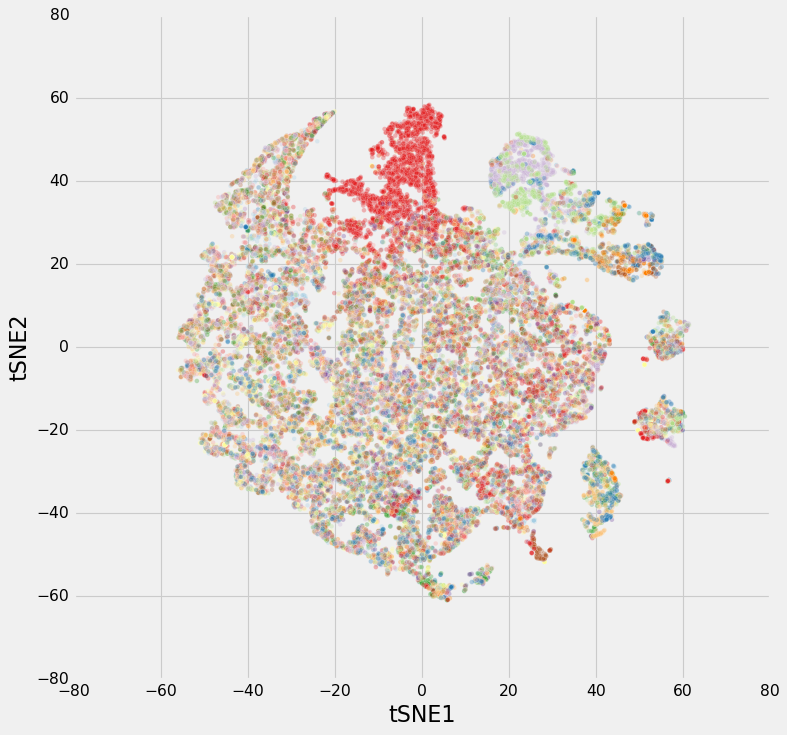

In [100]:
X['x']=X_tsne[:,0]
X['y']=X_tsne[:,1]
plt.style.use('fivethirtyeight')
X['label']=y
fig,axs=plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(
    x='x',
    y='y',
    hue='label',
    data=X,
    palette='Paired',
    alpha=.3,
    ax=axs,
    size=60
)
plt.legend().remove()
plt.xlabel('tSNE1',fontsize=20)
plt.ylabel('tSNE2',fontsize=20)
#axs.axis('off')
plt.savefig('../results/ncbi_tSNE_pp100.png',dpi=450)

In [110]:
numts.columns

Index(['eg2_value', 'e_value', 'genomic_id', 'genomic_start',
       'mitochondrial_start', 'genomic_length', 'mitochondrial_length',
       'genomic_strand', 'mitochondrial_strand', 'genomic_size',
       'genomic_sequence', 'mitochondrial_sequence', 'organism_name',
       'organism_label', 'numt_gc', 'g_gc', 'full_g_size', 'scaffolds_number',
       'genes_number', 'proteins_number', 'full_mt_size', 'mt_gc', 'mt_cds',
       'modk2', 'score', 'x', 'y'],
      dtype='object')

In [101]:
numts['x']=X['x']
numts['y']=X['y']

In [102]:
fil1=numts['x']<30

In [103]:
X1=numts[fil1]

In [104]:
fil2=X1['x']>20

In [105]:
X2=X1[fil2]

In [106]:
fil3=X2['y']<40

In [107]:
X3=X2[fil3]

In [108]:
X3[X3['y']>30]['organism_name'].value_counts()

Equus asinus                179
Elephantulus edwardii       116
Camelus ferus                24
Suricata suricatta           19
Ursus americanus             17
Felis catus                  16
Camelus dromedarius           5
Galeopterus variegatus        4
Nomascus leucogenys           3
Panthera leo                  2
Camelus bactrianus            2
Meles meles                   2
Sus scrofa                    2
Rousettus aegyptiacus         2
Vicugna pacos                 2
Puma concolor                 2
Bos taurus                    1
Erinaceus europaeus           1
Callithrix jacchus            1
Mustela erminea               1
Pan troglodytes               1
Oryctolagus cuniculus         1
Ursus maritimus               1
Desmodus rotundus             1
Acinonyx jubatus              1
Rhinopithecus roxellana       1
Vulpes lagopus                1
Ornithorhynchus anatinus      1
Name: organism_name, dtype: int64

In [154]:
numts.columns

Index(['eg2_value', 'e_value', 'genomic_id', 'genomic_start',
       'mitochondrial_start', 'genomic_length', 'mitochondrial_length',
       'genomic_strand', 'mitochondrial_strand', 'genomic_size',
       'genomic_sequence', 'mitochondrial_sequence', 'organism_name',
       'organism_label', 'numt_gc', 'g_gc', 'full_g_size', 'scaffolds_number',
       'genes_number', 'proteins_number', 'full_mt_size', 'mt_gc', 'mt_cds',
       'modk2', 'score', 'x', 'y'],
      dtype='object')

Sarcophilus parameter: 0.1428201071980095
Equus parameter: 0.2080367582770887
Equus parameter: 0.2027325540540821


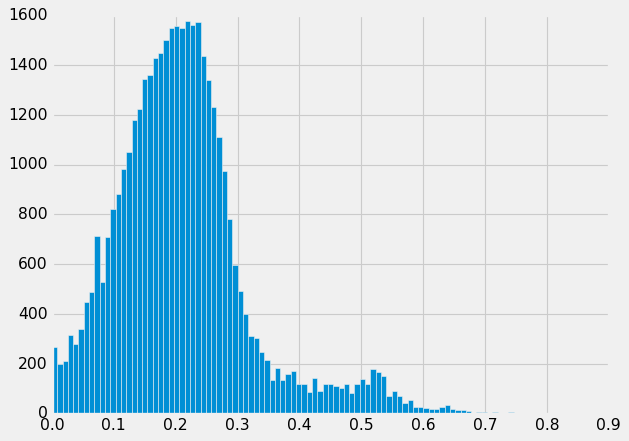

In [175]:
parameter='modk2'
numts[parameter].hist(bins=100)
print(f"Sarcophilus parameter: {np.median(numts.loc[numts['organism_name']=='Sarcophilus harrisii'][parameter])}")
print(f"Equus parameter: {np.median(numts.loc[numts['organism_name']=='Equus asinus'][parameter])}")
print(f"Equus parameter: {np.median(numts.loc[numts['organism_name']=='Elephantulus edwardii'][parameter])}")

0.14646588581586664

In [141]:
np.mean(numts.loc[numts['organism_name']=='Elephantulus edwardii']['modk2'])

0.20409644824999587

In [140]:
np.mean(numts.loc[numts['organism_name']=='Elephantulus edwardii']['modk2'])

,eg2_value,e_value,genomic_id,genomic_start,mitochondrial_start,genomic_length,mitochondrial_length,genomic_strand,mitochondrial_strand,genomic_size,...,scaffolds_number,genes_number,proteins_number,full_mt_size,mt_gc,mt_cds,modk2,score,x,y
19166,0.0,0.00000,NW_006400215.1,157045.0,658.0,3226.0,3235.0,+,+,824570.0,...,1242317.0,35092.0,25209.0,0.016552,37.8746,13.0,0.042483,2854.0,-31.328236,37.561443
19167,0.0,0.00000,NW_006399907.1,2585346.0,4968.0,3369.0,3381.0,+,+,8200175.0,...,1242317.0,35092.0,25209.0,0.016552,37.8746,13.0,0.096341,2657.0,-34.776070,37.279564
19168,0.0,0.00000,NW_006399765.1,28998936.0,7586.0,3179.0,3200.0,+,+,29796289.0,...,1242317.0,35092.0,25209.0,0.016552,37.8746,13.0,0.089696,2489.0,-34.625080,36.525013
19169,0.0,0.00000,NW_006400060.1,622412.0,8167.0,2423.0,2427.0,+,+,2785854.0,...,1242317.0,35092.0,25209.0,0.016552,37.8746,13.0,0.142354,1643.0,-36.678482,29.227776
19170,0.0,0.00000,NW_006400327.1,1244.0,3227.0,2935.0,2947.0,+,+,221597.0,...,1242317.0,35092.0,25209.0,0.016552,37.8746,13.0,0.181513,1493.0,-41.253403,31.257381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20969,2.5,0.00054,NW_006399974.1,711894.0,14421.0,89.0,93.0,+,-,5052039.0,...,1242317.0,35092.0,25209.0,0.016552,37.8746,13.0,0.190349,36.0,52.686848,-19.815184
20970,2.5,0.00054,NW_006399978.1,3813973.0,317.0,56.0,56.0,+,-,4558982.0,...,1242317.0,35092.0,25209.0,0.016552,37.8746,13.0,0.220916,36.0,57.519047,-23.436419
20971,2.5,0.00054,NW_006400017.1,529664.0,333.0,56.0,56.0,+,-,3581082.0,...,1242317.0,35092.0,25209.0,0.016552,37.8746,13.0,0.203483,36.0,57.153229,-23.193769
20972,2.5,0.00054,NW_006400060.1,2343573.0,402.0,74.0,74.0,+,-,2785854.0,...,1242317.0,35092.0,25209.0,0.016552,37.8746,13.0,0.203063,36.0,58.026199,-23.804365
